In [1]:
import tensorflow as tf
import numpy as np

In [9]:
class SOM:
    def __init__(self,width,height,dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()
        
        nodes = tf.Variable(tf.random_normal([width*height,dim]))
        self.nodes = nodes
        
        x = tf.placeholder(tf.float32, [dim])
        iter = tf.placeholder(tf.float32)
        
        self.x = x
        self.iter = iter
        
        bmu_loc = self.get_bmu_loc(x)
        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)
        
    def get_propagation(self, bmu_loc, x, iter):
        num_nodes = self.width * self.height
        rate = 1.0 - tf.div(iter, self.num_iters)
        alpha = rate * 0.5
        sigma = rate * tf.to_float(tf.maximum(self.width,self.height))/2.0
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc),0)
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.subtract(expanded_bmu_loc, self.node_locs)),1)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        rate = tf.multiply(alpha, neigh_factor)
        rate_factor = tf.stack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)])
        nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(num_nodes)]), self.nodes))
        update_nodes = tf.add(self.nodes, nodes_diff)
        return tf.assign(self.nodes, update_nodes)
    
    def get_bmu_loc(self,x):
        expanded_x = tf.expand_dims(x,0)
        sqr_diff = tf.square(tf.subtract(expanded_x,self.nodes))
        dists = tf.reduce_sum(sqr_diff,1)
        bmu_idx = tf.argmin(dists,0)
        bmu_loc = tf.stack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx, self.width)])
        return bmu_loc
    
    def get_locs(self):
        locs = [[x,y] for y in range(self.height) for x in range(self.width)]
        return tf.to_float(locs)
    
    def train(self,data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.num_iters):
                if(i % 5 == 0):
                    print(i)
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x:data_x, self.iter: i})
            centroid_grid = [[] for i in range(self.width)]
            self.nodes_val = list(sess.run(self.nodes))
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            self.centroid_grid = centroid_grid

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

digits = load_iris()
print(digits.data.shape)

som = SOM(64, 64, 4)
som.train(digits.data)



(150, 4)
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [11]:
a = np.zeros((som.width,som.height))
for i in range(som.width):
    for j in  range(som.height):
        a[i,j] = np.linalg.norm(som.centroid_grid[i][j])

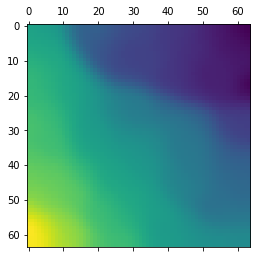

In [12]:
plt.matshow(a)
plt.show()